In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union
from scipy.stats import norm
import os
import glob
import openpyxl as xls
from datetime import datetime

In [27]:
link = os.getcwd()
folder = glob.glob('*')
data_link = link + "\\data.csv"
print(data_link)
#rate_link = link + "\\rate.csv"
#risk_link = link + "\\cac40.csv"

C:\Users\milan\OneDrive\Bureau\Projet\data.csv


In [28]:
data = pd.read_csv(data_link, index_col = "Dates", sep = ";", parse_dates = True)
risk = pd.DataFrame(data["SXXR Index"])
rate = pd.DataFrame(data["EONIA Index"])

**Ploting both EONIA and EUROSTOXX600 historical data**

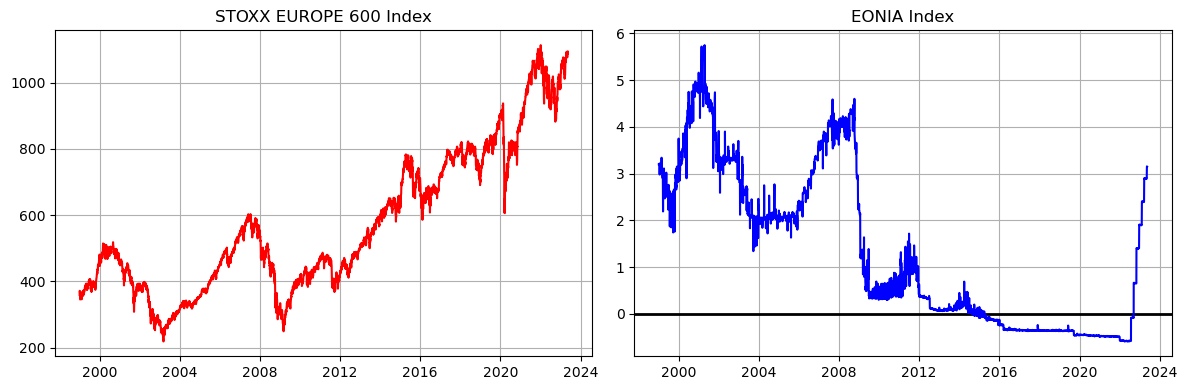

In [29]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(risk, c = "r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(rate, c = "blue")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [30]:
def investment_period(df:pd.DataFrame = risk, y0:Union[int,str]=2000, horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataframe
        - y0 : The year, if str, or the date in which the investor start to invest
        - horizon : the period of investment.
        - alldata : a boolean variable.
    
    This function is used to get the dataset during an "investment period", denoted by IP.
        - If alldata is True, the IP start from y0 to the end of the dataset
        - If alldata is False, the IP start from y0 to the y0 to y0+horizon-1
        - If y0's type is int, we include the last day of the previous year into the dataset.
    """
    if (alldata == False):
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T 
            # The period of investment
            table_investment_J = pd.DataFrame(df[str(y0):str(y0+horizon-1)])
            # concatenate
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            yyyy = int(y0[:4]) # Give the 4 first letters from yyyy-mm-dd
            mm_dd = y0[4:] # Give the remaining -mm-dd
            yyyh_mm_dd = str(yyyy+horizon-1) + mm_dd
            table_investment = pd.DataFrame(df[y0:yyyh_mm_dd])
    else:
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T
            table_investment_J = pd.DataFrame(df[str(y0):])
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            table_investment = pd.DataFrame(df[y0:])        
    return table_investment

In [31]:
def returns(df:pd.DataFrame=risk, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    Parameters:
        - df : The DataFrame
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
    
    This function allows to compute at first, the returns of the risk asset, from y0 to y0+horizon-1 (if alldata = False)
    or from y0 to the end (if alldata = True). Those return will be apply to the initial amount the client choose to invest
    at beginning
    """
    data = investment_period(df, y0, horizon, alldata)
    S0 = float(data.iloc[0])
    stock_returns = [(float(data.iloc[x])/S0 -1) for x in range(len(data)) ]
    stock_returns = np.array(stock_returns).reshape(-1,1)
    data["Risk return"] = initial_investment * (1 + stock_returns)
    data = data.drop(data.columns[0],axis = 1)
    return data

In [32]:
def monetarize(df:pd.DataFrame=rate, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataset
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
            
    This function allows to compute the investment to the safe asset (bond), by starting with the amount the investor
    paid.
    """
    data = investment_period(df, y0, horizon, alldata)
    bond_rate = [x for x in data.iloc[:,0]]
    bond_rate = np.array(bond_rate).reshape(-1,1)
    bond = []
    compteur = 0
    for i in bond_rate:
        if compteur == 0:
            bond.append(initial_investment)
        else:
            investment = float(bond[compteur-1] * (1 + i/(365*100)))
            bond.append(investment)
        compteur += 1
    data["RiskFree return"] = bond
    data = data.drop(data.columns[0], axis = 1)
    return data

In [33]:
def createxls(df:pd.DataFrame, opt:bool=False):
    # XLS futures names 
    now = datetime.now()
    yyyy = str(now.year)
    mm = str(now.month).zfill(2)
    dd = str(now.day).zfill(2)
    hour = str(now.hour).zfill(2)
    minute = str(now.minute).zfill(2)
    second = str(now.second).zfill(2)
    name = f"DataFrame_{yyyy}_{mm}_{dd}_{hour}_{minute}_{second}"
    # Create excel
    work = xls.Workbook()
    feuille = work.active #take the first sheet by default
    # Path
    path = os.getcwd()
    full_name = path + "\\01. Excel Data\\" + name +".xlsx"
    #Save :
    work.save(full_name)
    work.close()
    # Updated 
    df.to_excel(full_name, index = opt)
    print(f"The following excel is successfuly registered : {name}")

<AxesSubplot:>

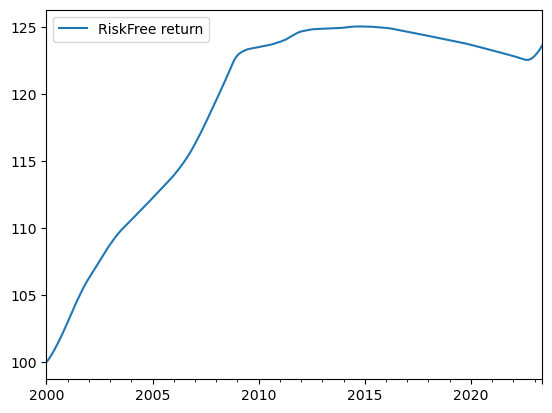

In [34]:
monetarize(alldata = True).plot()

<AxesSubplot:>

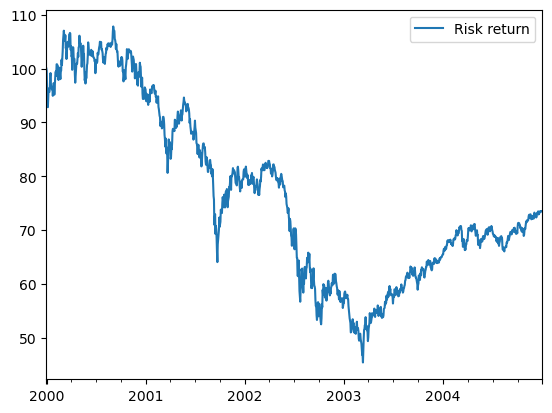

In [35]:
returns(initial_investment = 100).plot()

In [36]:
def bond(df:pd.DataFrame=rate, r:float=2, naming:str="Fixed"):
    ind = df.index
    rt = [r for i in range(len(ind))]
    df = pd.DataFrame({naming:rt}, index = ind)
    return df
rate2 = bond(rate, 2, "Fixed")

In [37]:
class Information:
    def __init__(self, dfrisk:pd.DataFrame=risk, dfrate:pd.DataFrame=rate, 
                 initial_investment:float=100.0, garant:float=1.0, y0:str="2000",
                 horizon:int=5, multiplier:float=2, activation:list=[3,6,9,12]):
        
        # Instance our 8 parameters
        self.dfrisk = pd.DataFrame(dfrisk.copy())
        self.dfrate = pd.DataFrame(dfrate.copy())
        self.initial_investment = initial_investment
        self.garant = garant
        self.y0 = y0
        self.horizon = horizon
        self.multiplier = multiplier
        self.activation = activation
        
        # Create others instances
        self.nb_days = len(self.dfrisk)
        self.nb_period_year = self.nb_days / self.horizon
        self.multip = multiplier
        
        # Date and Horizon's format : yyyy(-mm-dd) and (yyyy+h)(-mm-dd)
        self.yyyy = int(self.y0[:4])
        self.yyyh = str(self.yyyy + self.horizon-1)
        if len(self.y0)==4:
            self.inception = str(self.yyyy)
            self.end = self.yyyh
            self.onlyear = True
        elif len(self.y0)==7:
            self.mm = str(self.y0[5:7])
            self.inception = str(self.yyyy) + "-" + self.mm
            self.end = str(self.yyyh) + "-" + self.mm
            self.onlyear = False
        elif len(self.y0) == 10:
            self.mm = str(self.y0[5:7])
            self.dd = str(self.y0[8:10])
            self.inception = str(self.yyyy) + "-" + str(self.mm) + "-" + str(self.dd)
            self.end = str(self.yyyh) + "-" + str(self.mm) + "-" + str(self.dd)
            self.onlyear = False
    
    def period(self, tab:pd.DataFrame)->pd.DataFrame:
        """
        Parameter:
            - opt: tab
        Returns:
            - pd.DataFrame
        Description:
            This method allows to return tab from the inception to the end of the investment.
                - y0 is the string's parameters which is the investment's inception date. It could be by type 
                yyyy or yyyy-mm or yyyy-mm-dd.
                - horizon, which is type int, will be the horizon of investment. 
        
        """
        if self.onlyear:
            # Last data of previous year
            tab_JN = pd.DataFrame(tab[str(self.yyyy-1):str(self.yyyy-1)].iloc[-1]).T
            # Data from y0 to y0+horizon-1
            tab_J = tab[str(self.yyyy):self.yyyh]
            # Concatenate
            table = pd.concat([tab_JN, tab_J])
        else:
            table = pd.DataFrame(tab[self.inception:self.end])
        return table
    
    def check_period(self, opt:bool=False)->pd.DataFrame:
        """
        Parameter:
            - opt: bool
        Returns:
            - pd.DataFrame
        Description:
            This method allows to give a screen about our data:
                - If opt is True: It returns the screen about risky asset
                - If opt is False: It returns the screen about free-risk asset
        """
        if opt:
            tab = pd.DataFrame(self.dfrisk.copy())
        else:
            tab = pd.DataFrame(self.dfrate.copy())
        
        table = self.period(tab)
        return table
    
    def zooming(self, data:pd.DataFrame, inception:str, end:str):
        return data.loc[inception:end]
    
    def pct_returns(self, value:float=100, opt:bool=True)->pd.DataFrame:
        """
        Description:
            This method allows to get a DataFrame of the risky asset's returns in percentage. 
        """
        if opt:
            tab = self.check_period(True)
        else:
            tab = self.dfrisk
        S0 = float(tab.iloc[0,0])
        stock_returns = [(float(tab.iloc[x])/S0 -1) for x in range(len(tab))]
        stock_returns = np.array(stock_returns).reshape(-1,1)
        tab["Risky return"] = value * (1 + stock_returns)
        tab = tab.drop(tab.columns[0],axis = 1)
        return tab
    
    def returns(self, col_name:str="Risk return", opt:bool=True, typing:bool=True)->pd.DataFrame:
        """
        Parameters:
            col_name:str
            opt:bool
            typing:bool
        Returns:
            pd.DataFrame
        Description:
            This method allows to get a DataFrame of the risky asset's returns.
            if:
                - opt is True, get the returns from the inception to the end of the INVESTMENT,
                - opt is False, get the returns to the whole data of risky asset
                - typing is True, get the net returns in %, i.e, (S[t]/S[t-1])-1
                - typing is False, get the log-returns in %, i.e, log(S[t]/S[t-1])
        """
        if opt:
            tab = self.check_period(True)
        else:
            tab = pd.DataFrame(self.dfrisk.copy())
        S0 = tab.iloc[0,0]
        stock_returns = [1.0] #100%
        for i in range(len(tab)):
            if i == 0 :
                pass
            else:
                stock_returns.append(float(tab.iloc[i,0])/float(tab.iloc[i-1,0]))
        stock_returns = np.array(stock_returns).reshape(-1,1)
        if typing:
            tab[col_name] = (stock_returns - 1) * 100
        else:
            tab[col_name] = np.log(stock_returns) * 100
        tab = tab.drop(tab.columns[0],axis = 1)
        return tab
    
    def rolling_volatility(self, nb_days:int=90, amplitude:float=np.sqrt(256)*100,opt:bool=True)->pd.DataFrame:
        """
        Parameters:
            nb_days: int
            amplitude: float
        Return:
            pd.DataFrame
        Description:
            This method allows to compute the volatility with a windows of nb_days days from the inception of
            the risk dataframe to the end, by using the method "returns", in which it computes the daily returns 
            and we can apply a window to compute the standard deviation. Once computed, it returns data from
            the inception of the investment to the end of the investment.
            The parameter "amplitude" allows adjusting the volatility to a larger or a smaller scale.
            When the parameter amplitude equals to np.sqrt(256), it computes the annualized volatility.
        """
        tab = self.returns(opt=False,typing=False) # Log-returns
        vol_df = (tab.rolling(window = nb_days).std()) * amplitude
        
        if opt:
            dff = self.period(vol_df)
        else:
            dff = vol_df
        ind = dff.index
        vol_list = [vol for vol in dff.iloc[:,0]]
        vol_tab = pd.DataFrame({"Volatility":vol_list}, index = ind)
        return vol_tab
    
    def constant_information(self)->pd.DataFrame:
        """
        Description:
            This method allows to get a DataFrame which show logically known data:
                - Risk return,
                - Rate,
                - Time (int)
        """
        # Create constant information : Risk return, Rate
        risk0 = self.returns("Risk return %")
        norisk0 = self.check_period(False)
        tab_vol = self.rolling_volatility(nb_days=90, amplitude=np.sqrt(256),opt=True)
        t = pd.DataFrame({"t":range(len(risk0))}, index = risk0.index)
        table = pd.concat([t, risk0, norisk0, tab_vol], axis = 1)
        return table
    

In [38]:
class CPPI(Information):    
    def date_index(self)->list:
        """
        This method allows getting a list of dates, in which the fund updates the floor, periodically.
        For example, if self.activation = [3,6,9,12], it means that each quater, the floor will be 
        updated such that it reaches the level of self.garant * the previous VL.
        """
        table = self.constant_information()#[0]
        nb_len = len(table)
        # Date
        year_begin = int(str(table.index[0])[:4])
        year_end = int(str(table.index[-1])[:4])
        month_begin = int(str(table.index[0])[5:7])
        month_end = int(str(table.index[-1])[5:7])
        
        # Initialize
        monthly = [month_index for month_index in self.activation if month_index > month_begin]
        trim = [str(table.index[0])] # Last day of past year
        
        # Looping
        for year in range(year_begin,year_end):
            if year==year_begin:
                for month in monthly:
                    if len(str(month))==1:
                        mm = "0" + str(month)
                    else:
                        mm = str(month)
                    yyyymm = str(year) + "-" + mm
                    trim.append(str(table.loc[yyyymm].index[0]))
            else:
                for month in self.activation:
                    yyyy = str(year)
                    if len(str(month))==1:
                        mm = "0" + str(month)
                    else:
                        mm = str(month)
                    yyyymm = yyyy + "-" + mm
                    trim.append(str(table.loc[yyyymm].index[0]))
        last_part = table.loc[trim[-1]:].index[-1]
        trim.append(str(last_part))
        return trim
    
    def check_screen(self, data:pd.DataFrame, inception:str, end:str)->pd.DataFrame:
        """
        Parameters:
            - data: pd.DataFrame,
            - inception: str,
            - end: str
        Description:
            This method allows to get a DataFrame, from "inception" to "end"
        """
        return data.loc[inception:end]
    
    def garantide(self, value:float, opt:bool=True)->float:
        """
        Parameters:
            - value: float,
            - opt: bool
        Description:
            This method allows to get the guaranteed value (GV).
            if:
                - opt is True: the GV is simply the value that we enter in the parameter
                - opt is False: the GV will be the "garant" parameters of the initial investment.
        """
        if opt:
            garantia = value
        else:
            garantia = self.garant * self.initial_investment
        return garantia
    
    def garantie(self, value:float, inception:str, end:str, opt:bool = True)->pd.DataFrame:
        """
        Parameters:
            - value: float,
            - inception:str,
            - end: str,
            - opt: bool
        Description:
            This method allows to add a column of the guaranteed value. These value will firstly be fixed.
            In another method, the guaranteed value will be discounted and therefore will become the "floor"
        """
        info = self.constant_information()
        table = self.check_screen(info, inception, end)
        val = self.garantide(value,opt)
        table2 = pd.DataFrame(table.copy())
        table2.loc[:,"Garantie"] = val
        return table2
    
    def flooring(self, value:float, inception:str, end:str, opt:bool = True)->pd.DataFrame:
        """
        Parameters:
            - value: float,
            - inception:str,
            - end: str,
            - opt: bool
        Description:
            This method allows to compute the floor, which varies everyday. In the C.P.P.I model, the floor 
            is important because the VL should not reach it in downside. The floor's formula depend on the 
            guaranteed capital (for instance, 100% of the initial investment) in which we should discounted it.
        """
        table = self.garantie(value, inception, end, opt)
        # Initialization
        r = list(table.iloc[:,2]) # norisk
        t = list(table.iloc[:,0]) # t
        garanteed_capital = list(table.iloc[:,4]) # Garantie
        planche = np.zeros((len(table),1))
        nb_period = self.nb_days/self.horizon # Business day, by mean
        
        for k in range(len(table)):
            planche[k] = garanteed_capital[k] / ((1 + (r[k]/100))**(self.horizon - t[k]/nb_period))
        
        table["Floor"] = planche
        return table
    
    def liquidevalue(self, value:float, opt:bool):
        """
        Parameters:
            - value: float,
            - opt: bool
        Description:
            This method returns the:
                - either the value that we put as parameter, if opt = True
                - or the initial investment if opt = False
        """
        if opt:
            VL = value
        else:
            VL = self.initial_investment
        return VL
    
    def vol_multiplier(self, vol:float):
        if (vol<10) and (vol>0):
            return 7
        elif vol < 20:
            return 4
        elif vol < 30:
            return 3
        elif vol < 40:
            return 2
        elif vol < 50:
            return 1
        else:
            return 0

    def principale(self, value_garant:float, value_invest:float,vol_opt:bool, inception:str, end:str, opt:bool = True)->pd.DataFrame:
        """
        Parameters:
            - value_garant: float,
            - value_invest: float,
            - inception: str,
            - end: str,
            - opt: bool
        Description:
            This method is the key one of this class. It returns every informations of the table.
            By "informations", we meant 
                - known value (time, risk data, free risk data, floor)
                - unknown value (cushion, multiple, data before and after adjustment etc...)
        """
        # Known data
        table = self.flooring(value_garant, inception, end, opt)
        time = list(table.iloc[:,0])
        risk = list(table.iloc[:,1])
        norisk = list(table.iloc[:,2])
        volatility = list(table.iloc[:,3])
        plancher = list(table.iloc[:,5])

        
        # Initialization:

        val = [value_invest] #1
        cushion = [val[0] - plancher[0]] #2
        if vol_opt:
            multipl = self.vol_multiplier(volatility[0])
        else:
            multipl = self.multiplier#first_multiplier()
        
        if (cushion[0] * multipl <= self.initial_investment):
            ########
            # If the C[0] * m <= VL[0], it means that we can buy Cushion*m€ of the risky asset
            ########
            risky_before_adj = [cushion[0] * multipl] #3
            multiplier_adj = [multipl] #8
        else:
            ########
            # If C[0] * m > VL[0], i.e we buy a higher amount of risky asset such that the
            # initial amount couldn't handle it. Therefore, we only can initialize the 
            # risky asset with the whole amount of the initial investment, and 0€ of B[t]
            ########
            risky_before_adj = [val[0]]
            multiplier_adj = [val[0]/cushion[0]] #8
        norisk_before_adj = [val[0] - risky_before_adj[0]] #4
        multiplier_before_adj = [risky_before_adj[0] / cushion[0]] #5
        risky_adj = [risky_before_adj[0]] #6
        norisk_adj = [norisk_before_adj[0]] #7
        flow_adj = [0] #9     
        
        # Looping
        for t in range(len(table)):
            if t == 0:
                pass
            else:
                risky_before_adj.append(risky_adj[t-1] * (1 + risk[t]/100)) 
                norisk_before_adj.append(norisk_adj[t-1] * (1 + norisk[t]/(100*self.nb_period_year)))   
                val.append(risky_before_adj[t] + norisk_before_adj[t])
                
                if vol_opt:
                    multipl = self.vol_multiplier(volatility[t])
                
                ######### 
                # if flow_adjustment > 0 : We have to buy the risky asset (financed by the safe asset),
                # and reciprocally, i.e if flow_adjustment < 0, we have to buy the safe asset (financed by the risky asset)
                #########
                if (val[t-1] >= plancher[t-1]): 
                    ###########
                    # If liquidative value is greater than the floor, i.e, the Cushion is positive
                    ###########
                    flow = 0
                    cushion.append(val[t] - plancher[t])
                    multiplier_before_adj.append(risky_before_adj[t]/cushion[t])

                    if (self.multiplier * cushion[t] - risky_before_adj[t] < norisk_before_adj[t]):
                        ###########
                        # If m*C[t] - E[t] = Flow[t] < B[t], which means that we can fully convert Bonds 
                        # into Risky asset if we have to buy it
                        ###########
                        flow = multipl * cushion[t] - risky_before_adj[t]
                    else: 
                        ###########
                        # Else, and if B[t] > 0, we only can (partially) buy the risky asset E[t] 
                        # with an amount of B[t]€ (which is not sufficiency enough)
                        ###########
                        if (norisk_before_adj[t] >= 0):
                            flow = norisk_before_adj[t]
                else: 
                    ###########
                    # If the Liquidative Value is lower than the Floor, we decide to totally monetarize, 
                    # i.e, 100% in Bond, by taking Flow[t] = E[t]
                    ###########
                    flow = -risky_before_adj[t]
                    cushion.append(0)
                    multiplier_before_adj.append(0)
                
                if (risky_before_adj[t] + flow > 0): 
                    ###########
                    # If the risky asset E[t] is high enough 
                    ###########
                    flow_adj.append(flow)
                else: 
                    ###########
                    # If the risky asset isn't high enough: 
                    # We only can sell the amount of E[t]€ to get some B[t]
                    ###########
                    flow_adj.append(-risky_before_adj[t])
                    
                risky_adj.append(risky_before_adj[t] + flow_adj[t])
                norisk_adj.append(norisk_before_adj[t] - flow_adj[t])
                if (cushion[t]!=0):
                    multiplier_adj.append(risky_adj[t]/cushion[t])
                else:
                    multiplier_adj.append(multipl)
                

        # Value attribution
        table["Liquidative Value"] = val
        table["Risk"] = risky_before_adj
        table["Safe asset"] = norisk_before_adj
        table["Cushion"] = cushion
        table["Multiplier before adj."] = multiplier_before_adj
        table["Flow Adjustment"] = flow_adj
        table["Risk with adj."] = risky_adj
        table["Safe Asset with adj."] = norisk_adj
        table["Multiplier with adj."] = multiplier_adj
        table["Volatility"] = volatility
        
        return table
    
    def combined(self, vol_opt:bool=False)->list:
        """
        Parameters:
            - vol_opt:bool
        Return:
            A list of pd.DataFrame
        Description:
            This method allows to combined each crucial information, from the method self.principal(...)
            inside a list. In other word, we sub-divise the data into many part, related to the parameter
            self.activation and the method self.date_index(), such that the guaranteed floor is regularly
            updated, according to the client's preference.
        """
        # Preparation
        data_ind = self.date_index()
        list_data = []
        m = 0
        
        for i in range(len(data_ind)-1):
            if i == 0:
                garant_val = self.garantide(self.garant * self.initial_investment, False) # Not obligation to enter an accurate Value, bcse False.
                data = self.principale(garant_val, self.initial_investment, vol_opt, data_ind[i], data_ind[i+1], False)
                list_data.append(data[:-1])
            else:
                last_data = list_data[-1]
                last_VL = float(last_data.iloc[-1,6])
                last_VL_gar = last_VL * self.garant
                new_VL = self.liquidevalue(last_VL, True)
                new_GV = self.garantide(last_VL_gar, True)
                data = self.principale(new_GV, new_VL, vol_opt, data_ind[i], data_ind[i+1], True)
                if i == len(data_ind)-2:
                    list_data.append(data)
                else:
                    list_data.append(data[:-1])
        return list_data    
    
    def cppi(self, vol_opt:bool=False)->pd.DataFrame:
        """
        Parameters:
            - vol_opt:bool
        Return:
            pd.DataFrame
        Description:
            Use the list of DataFrame from the method self.combined() and concatenate it with axis = 0
        """
        data_list = self.combined(vol_opt)
        data = pd.concat(data_list, axis = 0)
        data = data.drop(data.columns[0], axis = 1) #t
        return data
    
    def crucial(self, opt:bool=False, vol_opt:bool=False)->pd.DataFrame:
        """
        Parameter:
            - opt:bool
            - vol_opt:bool
        Return:
            pd.DataFrame
        Description:
            Returns only :
            - The Ricky asset returns,
            - the Liquidative Value, 
            - the Cushion
            - the Volatility
        """
        table = self.cppi(vol_opt)
        risky_val = table["Risk"].iloc[0]
        if opt:
            risk = self.pct_returns(risky_val)
        else:
            risk = self.pct_returns(self.initial_investment)
        tableVL = pd.DataFrame(table["Liquidative Value"])
        tableCoussin = pd.DataFrame(table["Cushion"])
        tablePlancher = pd.DataFrame(table["Floor"])
        tableVol = pd.DataFrame(table["Volatility"])
        df = pd.concat([risk, tableVL, tableCoussin, tablePlancher, tableVol], axis = 1)
        df = df.dropna(axis = 0)
        return df
        

In [39]:
fundfx = CPPI(dfrisk=risk, dfrate=rate2, 
                 initial_investment=100.0, garant=0.95, y0="2007",
                 horizon=5, multiplier=4, activation=[])
informationfx = fundfx.cppi(vol_opt=False) 
crucialfx = fundfx.crucial(vol_opt=False)

In [40]:
df_analysis_fx = pd.DataFrame(informationfx["Liquidative Value"])
df_analysis_fx

,Liquidative Value
2006-12-29,100.000000
2007-01-01,100.000695
2007-01-02,100.709510
2007-01-03,100.709101
2007-01-04,100.538422
...,...
2011-12-23,88.528913
2011-12-26,88.530260
2011-12-27,88.532235
2011-12-28,88.513283


<AxesSubplot:>

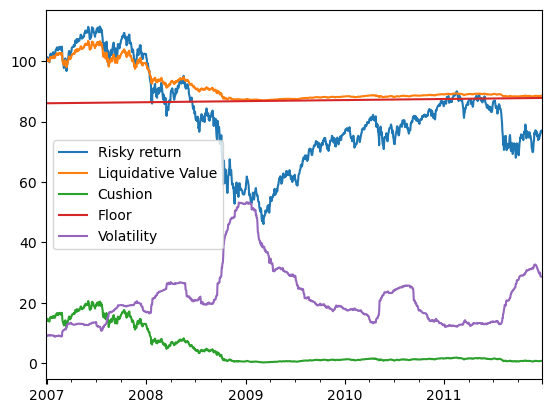

In [41]:
crucialfx.plot()

In [59]:
fund2005 = CPPI(dfrisk=risk, dfrate=rate, 
                 initial_investment=100.0, garant=0.85, y0="2014",
                 horizon=5, multiplier=5, activation=[1])
information2005 = fund2005.cppi(vol_opt=False) 
crucial2005 = fund2005.crucial(vol_opt=False)

<AxesSubplot:>

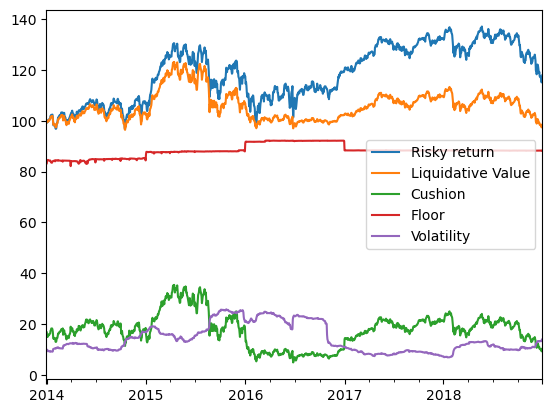

In [60]:
crucial2005.plot()

In [44]:
fund2007 = CPPI(dfrisk=risk, dfrate=rate, 
                 initial_investment=100.0, garant=1, y0="2007",
                 horizon=5, multiplier=3, activation=[1])
information2007 = fund2007.cppi(vol_opt=True) 
crucial2007 = fund2007.crucial(opt=True, vol_opt=True)
dfanalyses = pd.DataFrame(crucial2007["Liquidative Value"])

<AxesSubplot:>

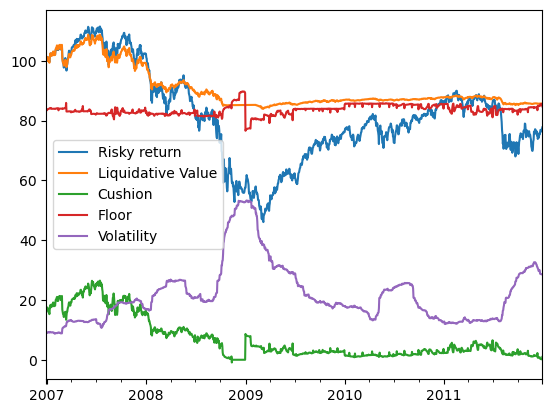

In [45]:
crucial2007.plot()

In [46]:
dfanalyses

,Liquidative Value
2006-12-29,100.000000
2007-01-01,100.000000
2007-01-02,101.268585
2007-01-03,101.265756
2007-01-04,100.907917
...,...
2011-12-26,85.707194
2011-12-27,85.707627
2011-12-28,85.703272
2011-12-29,85.708186


# Statistics

In [47]:
df_analyses = pd.DataFrame(crucial2007["Liquidative Value"])
ind = df_analyses.index
risk_analyses = risk.loc[ind]
riskless_analyses = rate.loc[ind]

In [48]:
class StatCPPI:
    def __init__(self, df:pd.DataFrame, dfrisk:pd.DataFrame, dfriskless:pd.DataFrame):
        self.df = pd.DataFrame(df.copy())
        self.dfrisk = pd.DataFrame(dfrisk.copy())
        self.dfriskless = pd.DataFrame(dfriskless.copy())
    
    def pct_data(self, data:pd.DataFrame)->pd.DataFrame:
        """
        Parameters:
            - data:pd.DataFrame
        Returns:
            - pd.DataFrame
        Description:
            This method returns the daily variation rate of the DataFrame "data"
        """
        tab = pd.DataFrame(data.copy())
        tab = tab.pct_change().fillna(0)
        return tab
    
    def mean(self, msg:bool=False, opt:bool=False)->float:
        """
        Parameters:
            - msg:bool
            - opt:bool
        Returns:
            - pd.DataFrame
        Description:
            - This method returns the mean of the returns
        """
        if opt:
            tab = pd.DataFrame(self.df.copy())
        else:
            tab = pd.DataFrame(self.dfrisk.copy())
        table = self.pct_data(tab)
        moy = float(table.mean())
        if msg:
            if opt:
                print(f"The Average of the Fund's return is : {round(moy*100,5)}%")
            else:
                print(f"The Average of the risky asset's return is : {round(moy*100,5)}%")
        else:
            pass
        return moy

    def returns(self, data:pd.DataFrame, col_name:str="Risk return", typing:bool=True)->pd.DataFrame:
        """
        Parameters:
            - data:pd.DataFrame
            - col_name:str
            - opt:bool
            - typing:bool
        Returns:
            pd.DataFrame
        Description:
            This method allows to get a DataFrame of the risky asset's returns, with log-returns.
            if:
                - opt is True, get the returns from the inception to the end of the INVESTMENT,
                - opt is False, get the returns to the whole data of risky asset
        """
        tab = pd.DataFrame(data.copy())
        S0 = tab.iloc[0,0]
        stock_returns = [1.0] #100%
        for i in range(len(tab)):
            if i == 0 :
                pass
            else:
                stock_returns.append(float(tab.iloc[i,0])/float(tab.iloc[i-1,0]))
        stock_returns = np.array(stock_returns).reshape(-1,1)
        if typing:
            tab[col_name] = (stock_returns - 1) * 100
        else:
            tab[col_name] = np.log(stock_returns) * 100
        tab = tab.drop(tab.columns[0],axis = 1)
        return tab
    
    def annualized_volatility_NAV(self, msg:bool=True)->float:
        """
        Parameters:
            - msg:bool
        Returns:
            - float
        Description:
            This method computes the annualized volatility of the Fund
        """
        tab = pd.DataFrame(self.df.copy())
        logreturns = self.returns(data = tab, col_name = "NAV Log-returns", typing=False)
        vol = float(logreturns.std()*np.sqrt(256))
        if msg:
            print(f"The annualized volatility of the strategy is : {round(vol,5)}%")
        else:
            pass
        return vol
    
    def annualized_volatility_risk(self, msg:bool=True)->float:
        """
        Parameters:
            - msg:bool
        Returns:
            - float
        Description:
            This method computes the annualized volatility of the risky asset
        """
        tab = pd.DataFrame(self.dfrisk.copy())
        logreturns = self.returns(data = tab, col_name = "Risk Log-returns", typing=False)
        vol = float(logreturns.std()*np.sqrt(256))
        if msg:
            print(f"The annualized volatility of the risky asset is : {round(vol,5)}%")
        return vol
    
    def variation_coeff(self, msg:bool=False, opt:bool=False)->float:
        """
        Parameters:
            - msg:bool
            - opt:bool
        Returns:
            - float
        Description:
            This method computes the variation's coefficient of the data
        """        
        if opt:
            dff = pd.DataFrame(self.df.copy())
            m = float(dff.mean())
            std = float(dff.std())
        else:
            dff = pd.DataFrame(self.dfrisk.copy())
            m = float(dff.mean())
            std = float(dff.std())
        if msg:
            if opt:
                print(f"The variation coefficient of the Fund is: {std/m}")
            else:
                print(f"The variation coefficient of the risky asset is: {std/m}")
        else:
            pass
        return std/m
    
    def annualized_returns(self, data:pd.DataFrame, msg:bool=False, opt:bool=True):
        """
        Parameters:
            - data:pd.DataFrame
            - msg:bool
            - opt:bool
        Returns:
            - float
        Description:
            This method computes the annualized returns of the "data"
        """
        tab = pd.DataFrame(data.copy())
        initiale = float(tab.iloc[0,0]) 
        finale = float(tab.iloc[-1,0])
        year_initiale = int(str(tab.iloc[0:,0].index[0])[0:4])
        year_finale = int(str(tab.iloc[0:,0].index[-1])[0:4])
        nb_year = year_finale-year_initiale
        rendement_ann = (finale/initiale)**(1/nb_year) -1
        
        if msg == True:
            if opt:
                print(f"The annualized return of the Fund is: {round(rendement_ann*100,5)}%")
            else:
                print(f"The annualized return of the risky asset is: {round(rendement_ann*100,5)}%")
        return rendement_ann
    
    def drawdown(self, data:pd.DataFrame, msg:bool=False,opt:bool=False)->float:
        """
        Parameters:
            - data:pd.DataFrame
            - msg:bool
            - opt:bool
        Returns:
            - float
        Description:
            This method computes the Maximum DrawDown of the "data"
        """
        tab = pd.DataFrame(data.copy())
        tab["DrawDown"] = 0
        n = len(tab)
        vl = [x for x in tab.iloc[:,0]]
        DD = []
        for i in range(len(vl)):
            if i < len(vl)-1:
                current = vl[i]
                draw = (min(vl[i+1:])/current)-1
                DD.append(draw)
        maxdraw = min(DD)

        themax_index = DD.index(maxdraw)
        if msg==True:
            if opt:
                print(f"The max drawdown of the Fund: {round(maxdraw*100,2)}%")
            else:
                print(f"The max drawdown of the risky asset is: {round(maxdraw*100,2)}%")
        return maxdraw
    
    def sharperatio(self, msg:bool=False, opt:bool=False)->float:
        """
        Parameters:
            - msg:bool
            - opt:bool
        Returns:
            - float
        Description:
            This method computes the Sharpe Ratio of:
                - The Fund, if opt is True
                - The risky asset, if opt is False
        """
        if opt:
            tab =  pd.DataFrame(self.df.copy())
        else:
            tab = pd.DataFrame(self.dfrisk.copy())
            
        rdmt_ann = self.annualized_returns(tab, False, True)
        
        rt = [x/100 for x in pd.DataFrame(self.dfriskless.copy()).iloc[:,0]]
        rt_mean = np.mean(rt)
        
        vol = self.annualized_volatility_NAV(False)
        
        sharpe = (rdmt_ann-rt_mean)/vol
        
        if msg == True:
            if opt:
                print(f"The Sharpe Ratio of the Fund is: {round(sharpe,5)}")
            else:
                print(f"The Sharpe Ratio of the risky asset is: {round(sharpe,5)}")
        return sharpe
    
    def value_at_risk(self, alpha:float=5, msg:bool=False, opt:bool=False)->float:
        """
        Parameters:
            - alpha:float
            - msg:bool
            - opt:bool
        Returns:
            - float
        Description:
            This method computes the alpha% Value At Risk of:
                - The Fund, if opt is True,
                - The risky asset, if opt is False
        """
        if opt:
            tab = pd.DataFrame(self.df.copy())
        else:
            tab = pd.DataFrame(self.dfrisk.copy())
        table = self.pct_data(tab)
        list_return = [rtn for rtn in table.iloc[:,0]]
        var = np.percentile(list_return,alpha)
        
        if msg:
            if opt:
                print(f"The Value-At-Risk at {alpha}% of the Fund is: {var}")
            else:
                print(f"The Value-At-Risk at {alpha}% of the risky asset is: {var}")
        else:
            pass
        return var
    
    def semi_sqrt(self, msg:bool=False, opt:bool=False)->float:
        """
        Parameters:
            - msg:bool
            - opt:bool
        Returns:
            - float
        Description:
            This method computes the semi-deviation:
                - The Fund, if opt is True,
                - The risky asset, if opt is False
        """
        if opt:
            tab = pd.DataFrame(self.df.copy())
        else:
            tab = pd.DataFrame(self.dfrisk.copy())
        table = self.pct_data(tab)
        neg_returns = [rtn for rtn in table.iloc[:,0] if rtn < 0]
        nb_neg_returns = len(neg_returns)
        square_neg_returns = [neg_rtn**2 for neg_rtn in neg_returns]
        semivariance = sum(square_neg_returns)/nb_neg_returns
        semideviation = np.sqrt(semivariance)
        if msg:
            if opt:
                print(f"The semi-deviation of the Fund is: {round(semideviation*100,5)}%")
            else:
                print(f"The semi-deviation of the risky asset is: {round(semideviation*100,5)}%")
        else:
            pass
        return semideviation
    
    def expected_shortfall(self, alpha:float = 5, msg:bool=False, opt:bool=False)->float:
        """
        Parameters:
            - alpha:float
            - msg:bool
            - opt:bool
        Returns:
            - float
        Description:
            This method computes the alpha% Expected Shortfall of:
                - The Fund, if opt is True,
                - The risky asset, if opt is False
        """
        if opt:
            tab = pd.DataFrame(self.df.copy())
        else:
            tab = pd.DataFrame(self.dfrisk.copy())
        table = self.pct_data(tab)
        critical_value = self.value_at_risk(alpha, False, opt)
        list_returns = [rtn for rtn in table.iloc[:,0] if rtn < critical_value]
        ES = np.mean(list_returns)
        
        if msg:
            if opt:
                print(f"The Expected Shortfall of the Fund is: {ES}")
            else:
                print(f"The Expected Shortfall of risky asset is: {ES}")
        return ES
    
    def message(self)->None:
        """
        Description:
            This method doesn't return anything, only messages. 
        """
        self.mean(msg=True, opt=False)
        self.mean(msg=True, opt=True)
        self.annualized_volatility_NAV(True)
        self.annualized_volatility_risk(True)
        self.variation_coeff(True, True)
        self.variation_coeff(True, False)
        self.annualized_returns(self.df, msg=True, opt=True)
        self.annualized_returns(self.dfrisk, msg=True, opt=False)
        self.drawdown(self.df, msg=True,opt=True)
        self.drawdown(self.dfrisk, msg=True,opt=False)
        self.sharperatio(msg=True,opt=True)
        self.sharperatio(msg=True,opt=False)
        self.value_at_risk(alpha=5, msg=True, opt=True)
        self.value_at_risk(alpha=5, msg=True, opt=False)
        self.expected_shortfall(alpha=5, msg=True, opt=False)
        self.expected_shortfall(alpha=5, msg=True, opt=True)
        self.semi_sqrt(True, True)
        self.semi_sqrt(True, False)
        
    def summary(self)->pd.DataFrame:
        """
        Return:
            - pd.DataFrame
        Description:
            This method return a DataFrame of comparison between the Fund and the risky asset
        """
        index = ["Mean (%)", "Ann. Volatility (%)", "Var. Coeff. (%)","Ann. Return (%)", "MaxDrawDown (%)", "Sharpe Ratio", "VaR 5%", 
                 "Exp. Shortfall", "Semi Deviation (%)"]
        meanNAV = self.mean(msg=False, opt=False)*100
        meanRisk = self.mean(msg=False, opt=True)*100
        volNAV = self.annualized_volatility_NAV(False)
        volRisk = self.annualized_volatility_risk(False)
        varcoeffNAV = self.variation_coeff(False, True)*100
        varcoeffRisk = self.variation_coeff(False, False)*100
        retNAV = self.annualized_returns(self.df, msg=False, opt=True)*100
        retRisk = self.annualized_returns(self.dfrisk, msg=False, opt=False)*100
        mddNAV = self.drawdown(self.df, msg=False,opt=True)*100
        mddRisk = self.drawdown(self.dfrisk, msg=False,opt=False)*100
        srNAV = self.sharperatio(msg=False,opt=True)
        srRisk = self.sharperatio(msg=False,opt=False)
        varNAV = self.value_at_risk(alpha=5, msg=False, opt=True)
        varRisk = self.value_at_risk(alpha=5, msg=False, opt=False)
        expshort_NAV = self.expected_shortfall(alpha=5, msg=False, opt=True)
        expshort_Risk = self.expected_shortfall(alpha=5, msg= False, opt=False)
        semsqrtNAV = self.semi_sqrt(False, True)*100
        semsqrtRisk = self.semi_sqrt(False, False)*100  
        NAVpart = [meanNAV, volNAV, varcoeffNAV, retNAV, mddNAV, srNAV, varNAV, expshort_NAV, semsqrtNAV]
        Riskpart = [meanRisk, volRisk, varcoeffRisk, retRisk, mddRisk, srRisk, varRisk, expshort_Risk, semsqrtRisk]
        dfNAV = pd.DataFrame({"Fund":NAVpart}, index = index)
        dfRisk = pd.DataFrame({"Risky Asset":Riskpart}, index=index)
        summary_data = pd.concat([dfNAV,dfRisk], axis=1)
        return summary_data

In [49]:
stat = StatCPPI(df=df_analysis_fx, dfrisk=risk_analyses, dfriskless=riskless_analyses)
stat.summary()

,Fund,Risky Asset
Mean (%),-0.007593,-0.008836
Ann. Volatility (%),5.008806,24.479794
Var. Coeff. (%),6.096347,18.742341
Ann. Return (%),-2.404677,-4.912967
MaxDrawDown (%),-18.472780,-58.689846
Sharpe Ratio,-0.008701,-0.013709
VaR 5%,-0.004921,-0.024856
Exp. Shortfall,-0.008842,-0.036780
Semi Deviation (%),0.349794,1.584666


In [50]:
createxls(informationfx,True)

The following excel is successfuly registered : DataFrame_2024_02_01_09_45_32
